In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = "../model/keypoint_classifier/new_keypoint.csv"
model_save_path = '../model/keypoint_classifier/new_keypoint.hdf5'
tflite_save_path = '../model/keypoint_classifier/new_keypoint.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 8

# Dataset reading

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd


# Read the dataset from the CSV file
data = pd.read_csv(dataset)

# Specify the target variable
balance_by = data.columns[0]

# Function to determine the sampling strategy
def sampling_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc = target_classes[target_classes == True].index
    sampling_strategy = {}
    for target in tc:
        sampling_strategy[target] = n_samples
    return sampling_strategy

# Calculate the median count for balancing
n_samples = int(data[balance_by].value_counts().median())

# Balancing the data using RandomUnderSampler and RandomOverSampler
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy(data.drop(balance_by, axis=1), data[balance_by], n_samples, t='majority'))
X_under, y_under = under_sampler.fit_resample(data.drop(balance_by, axis=1), data[balance_by])

over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy(X_under, y_under, n_samples, t='minority'))
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

balanced_data = pd.DataFrame(X_bal)
balanced_data[balance_by] = y_bal

# Print class distribution before resampling
unique_classes_before, class_counts_before = np.unique(data[balance_by], return_counts=True)
print("Class distribution before resampling:")
for class_label, count in zip(unique_classes_before, class_counts_before):
    print(f"Class {class_label}: {count} instances")

# Print class distribution after resampling
unique_classes_after, class_counts_after = np.unique(balanced_data[balance_by], return_counts=True)
print("\nClass distribution after resampling:")
for class_label, count in zip(unique_classes_after, class_counts_after):
    print(f"Class {class_label}: {count} instances")


Class distribution before resampling:
Class 0: 4223 instances
Class 1: 3929 instances
Class 2: 3871 instances
Class 3: 3283 instances
Class 4: 3242 instances
Class 5: 3256 instances
Class 6: 3223 instances
Class 7: 3837 instances

Class distribution after resampling:
Class 0: 3560 instances
Class 1: 3560 instances
Class 2: 3560 instances
Class 3: 3560 instances
Class 4: 3560 instances
Class 5: 3560 instances
Class 6: 3560 instances
Class 7: 3560 instances


In [5]:
balanced_data.head()

,0.0,0.0.1,0.23605150214592274,-0.3776824034334764,0.30472103004291845,-0.630901287553648,0.3605150214592275,-0.8412017167381974,0.2832618025751073,-0.9957081545064378,...,-0.5150214592274678,-0.2017167381974249,-0.5793991416309013,0.11158798283261803,-0.6738197424892703.1,0.15450643776824036,-0.51931330472103,0.04721030042918455,-0.4592274678111588,0
0,0.0,0.0,-0.404858,-0.040486,-0.708502,-0.048583,-0.923077,0.028340,-0.846154,0.048583,...,0.064777,-0.012146,-0.080972,-0.372470,0.287449,-0.315789,0.283401,-0.214575,0.145749,0
1,0.0,0.0,-0.188596,-0.083333,-0.337719,-0.232456,-0.442982,-0.364035,-0.535088,-0.451754,...,-0.934211,0.188596,-0.399123,0.258772,-0.552632,0.302632,-0.653509,0.333333,-0.750000,0
2,0.0,0.0,-0.099602,0.215139,-0.286853,0.362550,-0.366534,0.270916,-0.442231,0.003984,...,-0.155378,-0.521912,-0.657371,-0.163347,-0.426295,-0.095618,-0.310757,-0.203187,-0.334661,0
3,0.0,0.0,0.242537,-0.115672,0.347015,-0.272388,0.350746,-0.414179,0.335821,-0.537313,...,-0.951493,-0.175373,-0.335821,-0.194030,-0.552239,-0.201493,-0.679104,-0.205224,-0.805970,0
4,0.0,0.0,-0.215000,-0.050000,-0.410000,-0.165000,-0.565000,-0.250000,-0.710000,-0.250000,...,-0.960000,0.110000,-0.450000,0.200000,-0.590000,0.260000,-0.680000,0.310000,-0.765000,0


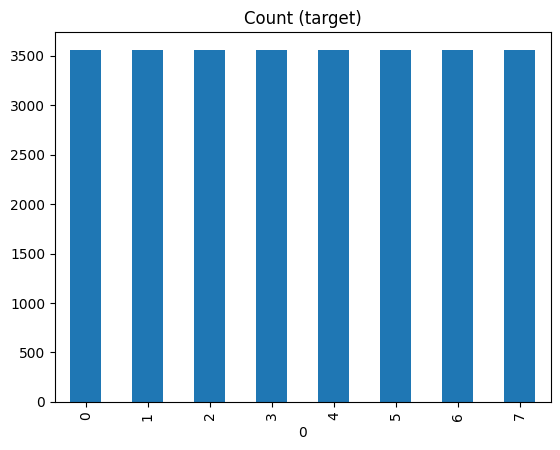

In [6]:
balanced_data["0"].value_counts().plot(kind='bar', title='Count (target)');

In [7]:
balanced_data["0"].count()

28480

In [8]:
X_dataset = np.array(balanced_data.drop(balance_by, axis=1))
X_dataset

array([[ 0.        ,  0.        , -0.4048583 , ...,  0.28340081,
        -0.2145749 ,  0.14574899],
       [ 0.        ,  0.        , -0.18859649, ..., -0.65350877,
         0.33333333, -0.75      ],
       [ 0.        ,  0.        , -0.09960159, ..., -0.31075697,
        -0.20318725, -0.33466135],
       ...,
       [ 0.        ,  0.        ,  0.27819549, ...,  0.4887218 ,
        -0.26315789,  0.44360902],
       [ 0.        ,  0.        ,  0.28712871, ...,  0.43564356,
        -0.14851485,  0.3960396 ],
       [ 0.        ,  0.        ,  0.22916667, ...,  0.40972222,
        -0.27777778,  0.41666667]])

In [9]:
y_dataset = np.array(balanced_data[balance_by])
y_dataset

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [12]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1158 (4.52 KB)
Trainable params: 1158 (4.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [14]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [15]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


164/167 [============================>.] - ETA: 0s - loss: 1.8187 - accuracy: 0.2875
Epoch 1: saving model to ../model/keypoint_classifier\new_keypoint.hdf5
167/167 [==============================] - 2s 5ms/step - loss: 1.8140 - accuracy: 0.2905 - val_loss: 1.4088 - val_accuracy: 0.5334
Epoch 2/1000
 37/167 [=====>........................] - ETA: 0s - loss: 1.4893 - accuracy: 0.4409

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/167 [=========================>....] - ETA: 0s - loss: 1.3809 - accuracy: 0.4773
Epoch 2: saving model to ../model/keypoint_classifier\new_keypoint.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 1.3637 - accuracy: 0.4840 - val_loss: 1.0256 - val_accuracy: 0.6215
Epoch 3/1000
153/167 [==========================>...] - ETA: 0s - loss: 1.1812 - accuracy: 0.5654
Epoch 3: saving model to ../model/keypoint_classifier\new_keypoint.hdf5
167/167 [==============================] - 1s 3ms/step - loss: 1.1775 - accuracy: 0.5676 - val_loss: 0.8884 - val_accuracy: 0.7374
Epoch 4/1000
158/167 [===========================>..] - ETA: 0s - loss: 1.0786 - accuracy: 0.6131
Epoch 4: saving model to ../model/keypoint_classifier\new_keypoint.hdf5
167/167 [==============================] - 1s 4ms/step - loss: 1.0773 - accuracy: 0.6136 - val_loss: 0.7910 - val_accuracy: 0.7611
Epoch 5/1000
152/167 [==========================>...] - ETA: 0s - loss: 1.0090 - accuracy: 0.6469
Epoch 5: sav

In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

56/56 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.9025


In [17]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [18]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 86ms/step
[6.3611643e-04 3.6903978e-09 4.7336403e-06 9.3752319e-01 6.1718997e-02
 7.5650314e-05 4.0410247e-05 8.8288851e-07]
3


# Confusion matrix

In [19]:
series = pd.Series(y_test)

# Use the value_counts method
value_counts_result = series.value_counts()

print(value_counts_result)


3    930
4    905
7    894
0    892
5    887
2    882
1    875
6    855
Name: count, dtype: int64


223/223 [==============================] - 0s 1ms/step
[0, 1, 2, 3, 4, 5, 6, 7]


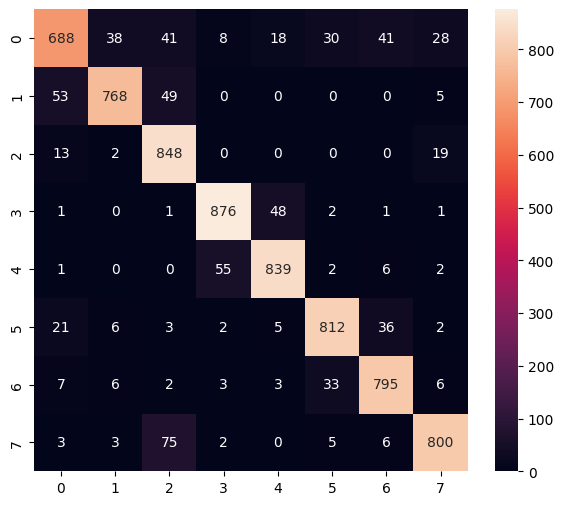

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       892
           1       0.93      0.88      0.90       875
           2       0.83      0.96      0.89       882
           3       0.93      0.94      0.93       930
           4       0.92      0.93      0.92       905
           5       0.92      0.92      0.92       887
           6       0.90      0.93      0.91       855
           7       0.93      0.89      0.91       894

    accuracy                           0.90      7120
   macro avg       0.90      0.90      0.90      7120
weighted avg       0.90      0.90      0.90      7120



In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    print(labels)
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [21]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Year 3\FYP\Modelling\fyp_modelling\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmp10k7agiv\assets


INFO:tensorflow:Assets written to: C:\Users\SHERMA~1\AppData\Local\Temp\tmp10k7agiv\assets


6720

# Inference test

In [23]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [24]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
input_data = np.array([X_test[0]], dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [26]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.3611555e-04 3.6903907e-09 4.7336266e-06 9.3752319e-01 6.1718967e-02
 7.5650169e-05 4.0410210e-05 8.8288510e-07]
3


In [28]:
y_test[0]

3